In [627]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.reset_defaults()
sns.set_theme(rc={"figure.dpi": 72, "savefig.dpi": 300,
              "figure.autolayout": True})
sns.set_style("ticks")
sns.set_context("paper")

np.set_printoptions(precision=4)


In [628]:
# Part a

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

# Load the data set
df = pd.read_csv("data/P3/crx.data", header=None, na_values="?")

# Drop rows with missing values in target feature
df.dropna(subset=[15], inplace=True)
df.drop_duplicates(inplace=True)

X = df.drop(columns=[15])
y = df[15] == '+'
X, y = X.values, y.values

# Impute missing values
X = SimpleImputer(strategy="most_frequent").fit_transform(X)

# Convert nominal to numeral
for i in range(X.shape[1]):
    X[:, i] = LabelEncoder().fit_transform(X[:, i])

# Normalization
X = StandardScaler().fit_transform(X)


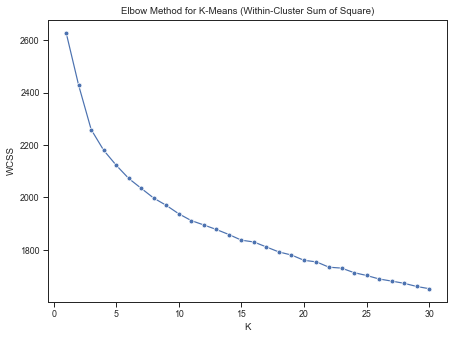

In [629]:
# Remove outliers using k-means

from sklearn.cluster import k_means


def Euclidean(x, X):
    """Return the Euclidean distances between
    an instance x and the dataset X."""
    return np.sqrt(np.sum((x - X)**2, axis=1))


def distance_from_center(X, centers, DistanceMetric=Euclidean):
    distance = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        dists = DistanceMetric(X[i], centers)
        distance[i] = np.min(dists)
    return distance


def kmeans_elbow(X, max_k=30, fig_path="P3_a_elbow.png"):
    K = list(range(1, max_k + 1))
    wcss = []
    for k in K:
        centers, *_ = k_means(X, k, random_state=7)
        distances = distance_from_center(X, centers)
        wcss.append(np.sum(distances))
    fig, ax = plt.subplots()
    ax.set(
        title="Elbow Method for K-Means (Within-Cluster Sum of Square)",
        xlabel="K",
        ylabel="WCSS"
    )
    sns.lineplot(x=K, y=wcss, marker="o", ax=ax)
    fig.savefig(fig_path)
    plt.show()


kmeans_elbow(X)


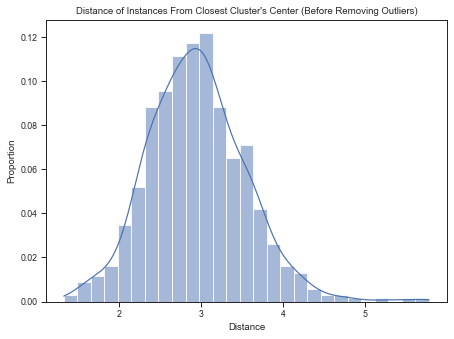

In [630]:
# Dataset status before removing outliers
centers, *_ = k_means(X, 7, random_state=7)
dist = distance_from_center(X, centers)
ax = sns.histplot(x=dist, kde=True, stat='proportion')
ax.set(title="Distance of Instances From Closest Cluster's Center (Before Removing Outliers)", xlabel='Distance')
plt.savefig('P3_a_before_outlier.png')
plt.show()


Proportion of outliers: 0.0072


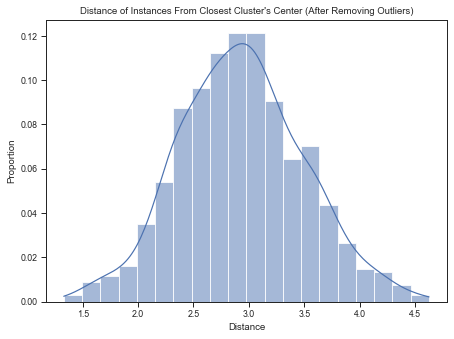

In [631]:
# Remove outliers
outlier_thr = 4.75
outlier_proportion = np.sum(dist >= outlier_thr) / len(y)
X = X[dist < outlier_thr]
y = y[dist < outlier_thr]
dist = dist[dist < outlier_thr]

# Dataset status after removing outliers
print('Proportion of outliers:', round(outlier_proportion, 4))
ax = sns.histplot(x=dist, kde=True, stat='proportion')
ax.set(title="Distance of Instances From Closest Cluster's Center (After Removing Outliers)", xlabel='Distance')
plt.savefig('P3_a_after_outlier.png')
plt.show()


In [632]:
# Split the data set

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.85, stratify=y, random_state=2)


In [633]:
import time
from sklearn.base import clone
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score, roc_auc_score)


def dprint(d):
    for k in d:
        print(f"{k}: {d[k]}")


def score(y_true, y_pred, labels=None):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return {
        'FN': int(fn),
        'FP': int(fp),
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, labels=labels),
        'Recall': recall_score(y_true, y_pred, labels=labels),
        'F1 Score': f1_score(y_true, y_pred, labels=labels),
    }


def eval(mdl, cv=1, disp=True, proba=False, thr=0.5):
    scores = []
    mname = mdl.__class__.__name__
    for i in range(cv):
        tt = time.time()
        mdl.fit(X_train, y_train)
        tt = time.time() - tt
        pt = time.time()
        if proba:
            y_pred = mdl.predict_proba(X_test)[:, 1] > thr
        else:
            y_pred = mdl.predict(X_test)
        pt = time.time() - pt
        s = score(y_test, y_pred)
        s["Training time"] = tt * 1000
        s["Predicting time"] = pt * 1000
        scores.append(s)
    s = pd.DataFrame(scores).mean().round(4).to_dict()
    s = dict({"Model": mname}, **s)
    if disp:
        print(f"Results for {mname}:")
        print("Accuracy:", s["Accuracy"])
        print("Precision:", s["Precision"])
        print("Recall:", s["Recall"])
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))
    else:
        return s


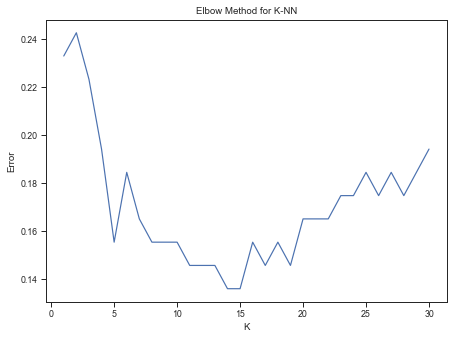

In [634]:
# Part b
from sklearn.neighbors import KNeighborsClassifier


def knn_elbow(max_k=30, fig_path="P3_b_elbow.png"):
    K = list(range(1, max_k + 1))
    err = []
    for k in K:
        mdl = KNeighborsClassifier(n_neighbors=k)
        mdl.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
        e = 1 - accuracy_score(y_test, y_pred)
        err.append(e)
    fig, ax = plt.subplots()
    ax.set(
        title="Elbow Method for K-NN",
        xlabel="K",
        ylabel="Error"
    )
    sns.lineplot(x=K, y=err, ax=ax)
    fig.savefig(fig_path)
    plt.show()


knn_elbow()


In [635]:
eval(KNeighborsClassifier(n_neighbors=13))


Results for KNeighborsClassifier:
Accuracy: 0.8544
Precision: 0.9167
Recall: 0.7333
Confusion Matrix:
[[55  3]
 [12 33]]


In [636]:
# Part c
from sklearn.tree import DecisionTreeClassifier
eval(DecisionTreeClassifier(), cv=10)


Results for DecisionTreeClassifier:
Accuracy: 0.7748
Precision: 0.7501
Recall: 0.7267
Confusion Matrix:
[[47 11]
 [12 33]]


In [637]:
# Part d
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

t = time.time()
gs_rf = GridSearchCV(
    estimator=RandomForestClassifier(),
    scoring='accuracy',
    cv=5,
    param_grid={
        'n_estimators': [30, 50, 100],
        'max_depth': list(range(5, 30)),
    }
).fit(X_train, y_train)
t = time.time() - t

print('Best Parameters for Random Forest:')
dprint(gs_rf.best_params_)
print("Elapsed time (s):", round(t, 4))


Best Parameters for Random Forest:
max_depth: 14
n_estimators: 50
Elapsed time (s): 36.4949


In [638]:
eval(clone(gs_rf.best_estimator_))


Results for RandomForestClassifier:
Accuracy: 0.8155
Precision: 0.7826
Recall: 0.8
Confusion Matrix:
[[48 10]
 [ 9 36]]


In [639]:
# Part e
from sklearn.naive_bayes import GaussianNB
eval(GaussianNB())


Results for GaussianNB:
Accuracy: 0.8544
Precision: 0.875
Recall: 0.7778
Confusion Matrix:
[[53  5]
 [10 35]]


In [640]:
# Part f
from sklearn.linear_model import LogisticRegression
eval(LogisticRegression())


Results for LogisticRegression:
Accuracy: 0.8447
Precision: 0.8085
Recall: 0.8444
Confusion Matrix:
[[49  9]
 [ 7 38]]


In [641]:
# Part g
from sklearn.svm import SVC

gs_svc = GridSearchCV(
    estimator=SVC(),
    scoring='accuracy',
    cv=3,
    param_grid={
        'C': [0.01, 0.1, 1, 10],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    }
).fit(X_train, y_train)

print('Best Parameters for SVM:')
dprint(gs_svc.best_params_)


Best Parameters for SVM:
C: 0.1
kernel: rbf


In [642]:
eval(clone(gs_svc.best_estimator_))


Results for SVC:
Accuracy: 0.8544
Precision: 0.8571
Recall: 0.8
Confusion Matrix:
[[52  6]
 [ 9 36]]


In [643]:
# Part h
from sklearn.ensemble import AdaBoostClassifier
eval(AdaBoostClassifier())


Results for AdaBoostClassifier:
Accuracy: 0.8155
Precision: 0.7708
Recall: 0.8222
Confusion Matrix:
[[47 11]
 [ 8 37]]


In [644]:
# Part i
from sklearn.cluster import KMeans
eval(KMeans(n_clusters=2))


Results for KMeans:
Accuracy: 0.8252
Precision: 0.9091
Recall: 0.6667
Confusion Matrix:
[[55  3]
 [15 30]]


In [645]:
# Part j

models = (
    KNeighborsClassifier(n_neighbors=13),
    DecisionTreeClassifier(),
    RandomForestClassifier(**gs_rf.best_params_),
    GaussianNB(),
    LogisticRegression(),
    SVC(**gs_svc.best_params_, probability=True),
    AdaBoostClassifier(),
    KMeans(n_clusters=2),
)

res = [eval(m, cv=20, disp=False) for m in models]
res = pd.DataFrame(res)
res.to_csv("P3_j.csv", index=False)
res.head(n=None)


,Model,FN,FP,Accuracy,Precision,Recall,F1 Score,Training time,Predicting time
0,KNeighborsClassifier,12.00,3.00,0.8544,0.9167,0.7333,0.8148,1.9017,4.8978
1,DecisionTreeClassifier,12.10,11.25,0.7733,0.7455,0.7311,0.7381,2.0504,0.0502
2,RandomForestClassifier,8.80,8.50,0.8320,0.8105,0.8044,0.8072,74.3101,5.9965
3,GaussianNB,10.00,5.00,0.8544,0.8750,0.7778,0.8235,0.7995,0.2004
4,LogisticRegression,7.00,9.00,0.8447,0.8085,0.8444,0.8261,2.7983,0.2000
5,SVC,9.00,6.00,0.8544,0.8571,0.8000,0.8276,74.4551,4.7970
6,AdaBoostClassifier,8.00,11.00,0.8155,0.7708,0.8222,0.7957,100.8447,8.3441
7,KMeans,23.25,31.60,0.4675,0.5269,0.4833,0.4896,35.5294,1.8491


In [649]:
# Part k

res = eval(
    LogisticRegression(),
    disp=False, proba=True, thr=0.56, cv=20,
)

dprint(res)


Model: LogisticRegression
FN: 7.0
FP: 7.0
Accuracy: 0.8641
Precision: 0.8444
Recall: 0.8444
F1 Score: 0.8444
Training time: 2.8037
Predicting time: 0.2491
